In [1]:
import matplotlib.style as style

%matplotlib inline
# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (15, 10)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['grid.color'] = '#eeeeee'
#rcParams['grid.color'] = 'white'
#rcParams['axes.facecolor'] = '#eeeeee'
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 16
rcParams['patch.edgecolor'] = 'none'

In [2]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
import scipy.stats as stats
from scipy.stats import normaltest
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

/Users/dimitriostheoharatos/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Start by reading in our data and breaking it down into our training and hold out set. I will do a 80-20 split since I only have ~300 samples. 

In [3]:
data = pd.read_csv('modeling_data.csv', index_col = 0)

In [4]:
data.head()

,0 beds,1 bath,1 bed,1 bedroom,1 guest,1 private bath,1 shared bath,1.5 baths,1.5 private baths,1.5 shared baths,...,price,ratings,rental_price_norm,reviews,superhost,entire_place,private_room,no_baths,shared_room,logprice
0,0,1,1,1,0,0,0,0,0,0,...,120,5.0,1.001234,239,1,1,0,0,0,4.787492
1,0,1,1,1,0,0,0,0,0,0,...,101,5.0,1.010097,219,1,1,0,0,0,4.615121
2,0,0,1,1,0,0,1,0,0,0,...,53,4.5,1.172587,324,0,0,1,0,0,3.970292
3,0,1,1,1,0,0,0,0,0,0,...,68,5.0,1.172587,616,1,1,0,0,0,4.219508
4,0,1,0,0,0,0,0,0,0,0,...,149,5.0,1.047322,339,1,1,0,0,0,5.003946


In [5]:
for column in data.columns:
    data[column] = data[column].apply(float) 
    

Make sure there are no NAs...

In [6]:
sum([sum(data[column].isna()) for column in data.columns])

0

In [7]:
data.describe()

,0 beds,1 bath,1 bed,1 bedroom,1 guest,1 private bath,1 shared bath,1.5 baths,1.5 private baths,1.5 shared baths,...,price,ratings,rental_price_norm,reviews,superhost,entire_place,private_room,no_baths,shared_room,logprice
count,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,...,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000
mean,0.005917,0.547337,0.704142,0.786982,0.050296,0.153846,0.142012,0.005917,0.008876,0.023669,...,99.029586,4.835799,1.011284,240.467456,0.662722,0.526627,0.337278,0.020710,0.029586,4.510646
std,0.076809,0.498492,0.457104,0.410047,0.218879,0.361336,0.349580,0.076809,0.093931,0.152240,...,41.822208,0.247461,0.097043,127.503420,0.473482,0.500031,0.473482,0.142623,0.169693,0.418258
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,25.000000,4.000000,0.823382,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.218876
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,69.000000,4.500000,0.927301,152.500000,0.000000,0.000000,0.000000,0.000000,0.000000,4.234107
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,92.000000,5.000000,1.010097,224.000000,1.000000,1.000000,0.000000,0.000000,0.000000,4.521789
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,125.000000,5.000000,1.055299,310.750000,1.000000,1.000000,1.000000,0.000000,0.000000,4.828314
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,333.000000,5.000000,1.172587,808.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.808142


Drop the max outlier since it is significantly larger than all of the other AirBnB listings. 

In [8]:
data = data[data.price!=333.0]

# Linear Regression Assumptions

To get a feel for our model, let's run a simple linear regression to ensure that it meets our expectations when it comes to the assumptions of linear regression.

In [9]:
X = data.drop(['price', 'logprice', 'price'], axis = 1)
y = data['price']

In [10]:
y = data['price']
model = LinearRegression()
model.fit(X, y)
pred = model.predict(X)

In [11]:
def check_linear_assumptions(y, pred):
    plt.subplot(1, 3, 1)
    res = y - pred
    plt.scatter(y, res)
    plt.title("Residual plot")
    plt.xlabel("response")
    plt.ylabel("residuals")

    plt.subplot(1, 3, 2)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    plt.hist(res)
    plt.title("Residual Histogram")

NormaltestResult(statistic=33.06699310985894, pvalue=6.600756007233095e-08)


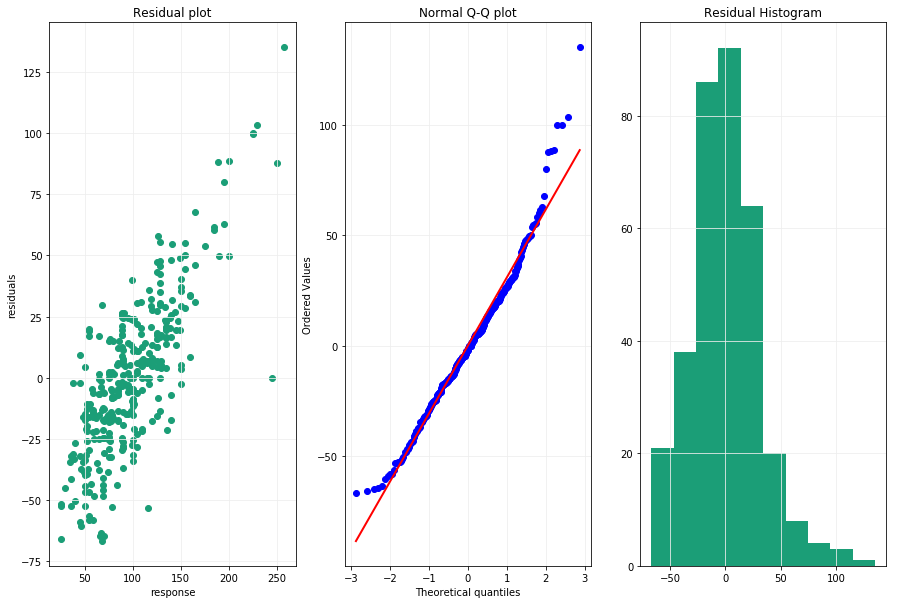

In [13]:
rcParams['figure.figsize'] = (15, 10)
check_linear_assumptions(y, pred)
print(normaltest(y-pred))

The residual plot doesn't seem to have too much of a pattern, though we do  start to notice heteroscedascity as our response is increasing. Our Q-Q plot also looks good for a majority of the theoretical quantile values but gets a bit wonky at the tails.  Finally, the histogram of the residuals almost looks normal but there is definitely a right skew.  Let's run a model on the square root of price instead to see if these issues are fixed. Also, the normality tests suggests that the underlying residual plot is certainly not normal based on the statistically significant p value. 

Let's try a transformation on the output to see if we get anything different. 

In [14]:
y = np.power(data['price'], 0.5)
model = LinearRegression()
model.fit(X, y)
pred = model.predict(X)

NormaltestResult(statistic=1.4962371311059943, pvalue=0.47325611601003637)

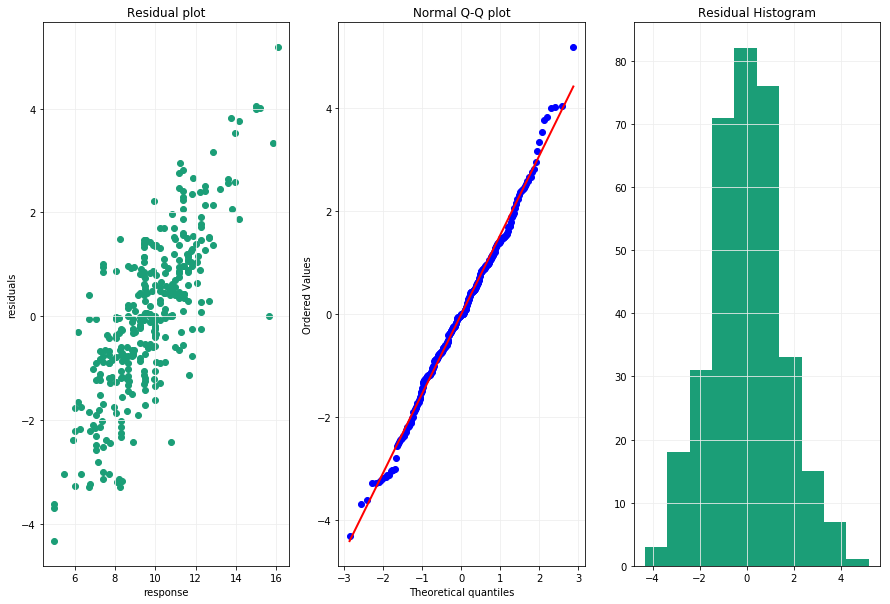

In [15]:
check_linear_assumptions(y, pred)
normaltest(y-pred)

This is a much better result.  Though there still seems to be some heteroscedascity in our residuals, it has definitely decreased and our normality test is passing. For the remainder of our analysis, we will use the square root of the price as our target variable in order to satisfy the assumptions of linear regression. Then, we will transform it back into normal price dollars when interpreting our coefficients. 

In [16]:
data['sqrt_price'] = np.power(data['price'], 0.5)

# Baseline Performance

We need to have some sort of baseline comparison to compare our model to.  A reasonable baseline performer in this case would be to take the average of all our rooms in our training set as our predictor. Then, for our holdout set, we will simply always predict this training average (of the square root of the price). This is implemented below:

In [17]:
X = data.drop(['price', 'logprice', 'sqrt_price'], axis = 1)
y = data['sqrt_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [19]:
def baseline_performer(y_train, y_test):
    preds = np.tile(np.array(np.mean(y_train)) , (len(y_test),))
    mse = mean_squared_error(y_test**2, preds**2)
    rmse = np.power(mse, 0.5)
    r2 = r2_score(y_test, preds)
    return mse, rmse, r2

mse_baseline, rmse_baseline, r2_baseline = baseline_performer(y_train, y_test)  


In [38]:
print("RMSE Baseline Model: $%.2f" % rmse_baseline)
print("Baseline R Squared: %.3f" % r2_baseline)

RMSE Baseline Model: $46.58
Baseline R Squared: -0.070


In [25]:
np.mean(y_train**2)

95.91449814126393

It looks like the RMSE of our baseline corresponds to approximately $47 error on average per prediction for our holdout set.  Since the average of our testing set is 96 or so dollars, our predictions are off by nearly 50% on average. Let's improve on this with linear regression!

# Basic Linear Regression


In [101]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mse_lr = mse(y_test**2, pred**2)
rmse_lr = np.power(mse_lr, 0.5)
print("MSE Simple Linear Model: %.2f" % mse_lr)
print("RMSE Simple Linear Model: $%.2f" % rmse_lr)
print("R2 Score Simple Linear Model: %.3f " % model.score(X_test, y_test))

MSE Simple Linear Model: 1412.28
RMSE Simple Linear Model: $37.58
R2 Score Simple Linear Model: 0.354 


It looks like we are greatly improving on the baseline model by integrating linear regression without any regularization or other more technical methods.  Let's look at the coefficients of our model to see which features are having the greatest impact. 

In [47]:
model.coef_

array([-6.58963603e-01, -7.63933672e-01, -1.15029840e+00,  3.56430065e-01,
       -1.15508499e+00, -2.39030928e-01, -4.47163096e-01,  1.66493296e-02,
       -1.11679218e-01, -9.79720665e-02, -3.63744877e-01,  1.68373264e-01,
       -1.04000118e+00, -7.82955514e-01,  8.82072193e-14,  1.34421441e-02,
        1.15849615e+00, -8.55522092e-01, -5.23640284e-01, -6.27018488e-01,
        1.69274695e+00, -5.58991103e-01, -3.01843212e-01,  4.46096612e+00,
       -1.57027012e+00, -5.29071550e-01,  5.05277753e-01,  9.79497283e-01,
        4.87788884e-01, -5.33490261e-01, -8.88178420e-16,  3.30718763e-01,
       -9.65541931e-01,  1.00291341e+00, -5.68637086e+00,  9.65541931e-01,
        1.48252251e+00, -2.21715565e+00,  2.82240525e-03, -1.70516240e-01,
        4.19606951e-01, -1.16087622e+00,  3.82097377e-02, -3.31021542e+00])

It looks like the most impactful coefficients in the negative direction are lattitude and shared room, with coefficients of -5.69 and -3.31 respectively. The most positive coefficients are 4.46 and 1.69, which correspond to 5 bedrooms and 3 shared baths (which makes sense since it implies there are many people allowed to stay at these respective places). 

We alredy are seeing a good amount of improvement with our simple linear model, but let's try and extract even more predictive power by integrating higher order polynomials and regularization. 

# Complexity Analysis

Let's first look at the complexity curves to see where we are under/over fitting with respect to the order of the polynomial. 

In [20]:
def complexity(x_train, y_train):
    train_error = np.empty(5)
    test_error = np.empty(5)
    for degree in range(5):
        est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        est.fit(X_train, y_train)
        train_error[degree] = mse(y_train, est.predict(X_train))
        test_error[degree] = mse(y_test, est.predict(X_test))

    # Plot the training and test errors against degree
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(5), np.log(train_error), label='train')
    plt.plot(np.arange(5), np.log(test_error), label='test')
    plt.ylim((0.0, 1e2))
    plt.ylabel('log(mean squared error)')
    plt.xlabel('degree')
    plt.legend(loc='upper left')
    
    return train_error, test_error

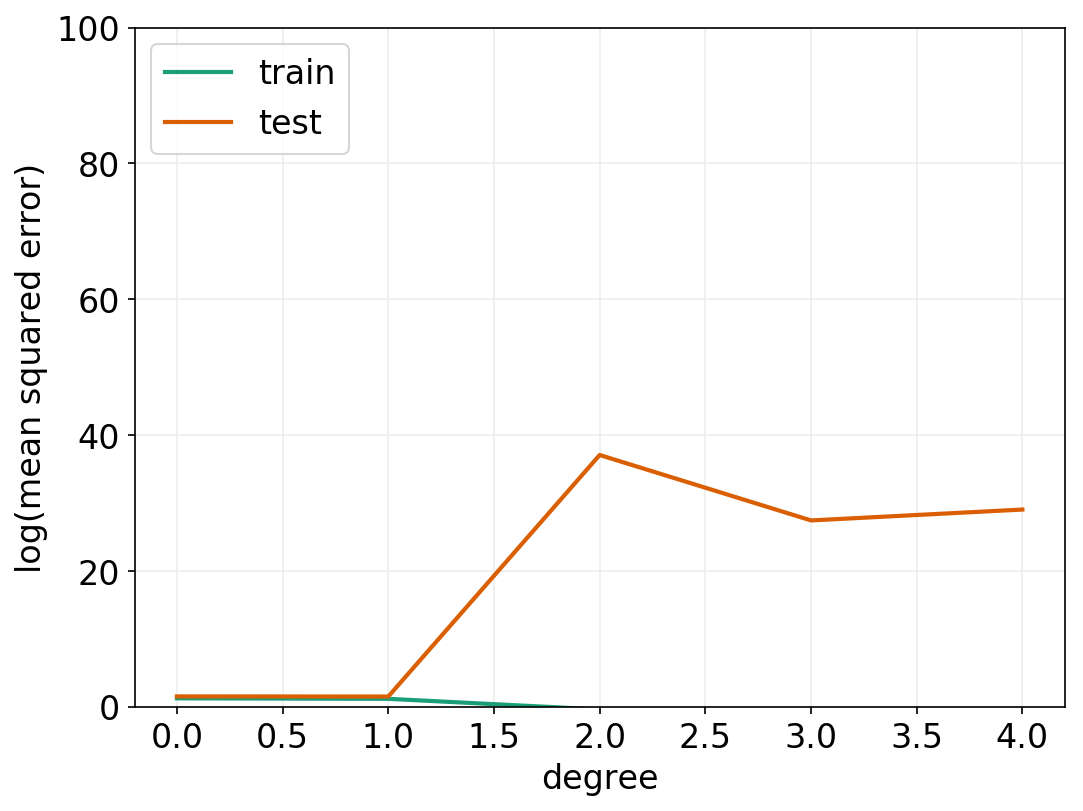

In [59]:
training_error, testing_error = complexity(X_train, y_train)

Based on the above complexity graph, it looks like we are overfitting at a second-degree polynomial.  Let's integrate regularization to reduce our feature space in the hopes to prevent overfitting.

# Regularization

In order to use regularization in our model we will first need to standardize our columns to have a mean 0 and standard deviation 1.  This is necessary since we want the cost function to be penalize the size of the coefficient of each feature regardless of that features scale.  Since most of our features are categorical in nature, this will not have a major impact on most features but certain continuous features (namely lattitude, longitude, rental_norm) may skew the regularization results. 

In [72]:
scaler = StandardScaler().fit(X_train)
standardized_X_train = scaler.transform(X_train)
standardized_X_test = scaler.transform(X_test)

In [128]:
#note that I toggled with the alphas setting, and this range gave me
#the lowest MSE
rcv = RidgeCV(cv=5, alphas = (np.arange(0,20,10)))
rcv.fit(standardized_X_train, y_train)
rcv_score1 = rcv.score(standardized_X_test, y_test)
print("Ridge R2 Order 1 Polynomial: %f "% rcv_score1)


Ridge R2 Order 1 Polynomial: 0.359835 


In [212]:
rcv_preds1 = rcv.predict(standardized_X_test)
mse_rcv1 = mse(y_test**2, rcv_preds1**2)
rmse_rcv1 = np.power(mse_rcv1, 0.5)
print("MSE Ridge Linear Model: %.2f" % mse_rcv1)
print("RMSE Ridge Linear Model: $%.2f" % rmse_rcv1)

MSE Ridge Linear Model: 1404.63
RMSE Ridge Linear Model: $37.48


It looks like we did not benefit much using ridge regularization for first order polynomials.  This is not totally surprising since we were not overfitting with a first order polynomial and thus ridge regresssion is not being utilized effectively.  Let's use an additional polynomial feature to see if this helps us. 

# Regularization with Higher Order Polynomials

In [208]:
poly = PolynomialFeatures(2)
X_2 = poly.fit_transform(standardized_X_train)
X_test_2 = poly.fit_transform(standardized_X_test)
rcv2 = RidgeCV(cv=5, alphas = np.arange(800,810,1))
rcv2.fit(X_2, y_train)
rcv2_score = rcv2.score(X_test_2, y_test)
print("Ridge R2 Order 2 Polynomial: %.2f "% rcv2_score)


Ridge R2 Order 2 Polynomial: 0.24 


In [213]:
rcv_preds2 = rcv2.predict(X_test_2)
mse_rcv2 = mse(y_test**2, rcv_preds2**2)
rmse_rcv2 = np.power(mse_rcv2, 0.5)
print("MSE Ridge Order 2: %.2f" % mse_rcv2)
print("RMSE Ridge Order 2: $%.2f" % rmse_rcv2)

MSE Ridge Order 2: 1586.68
RMSE Ridge Order 2: $39.83


It doesn't look like we are getting any additional predictive power by using a second degree polynomial with ridge regression.  Let's look into elastic net regularization so we can both induce sparsity and spread the impact of our distribution. 

In [209]:
elastic1 = ElasticNetCV(cv=5, alphas = (np.arange(0.01, 0.2, 0.001)), \
                        l1_ratio=[0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999])
elastic1.fit(standardized_X_train, y_train)
enet_score1 = elastic1.score(standardized_X_test, y_test)
print("Elastic Net R2 Order 1 Polynomial: %.2f "% enet_score1)


Elastic Net R2 Order 1 Polynomial: 0.30 


In [215]:
elastic1_preds = elastic1.predict(standardized_X_test)
enet_mse1 = mse(y_test**2,elastic1_preds**2)
enet_rmse1 = np.power(enet_mse1, 0.5)
print("Elastic Net MSE Order 1: %.2f "% enet_mse1)
print("Elastic Net RMSE Order 1: $%.2f "% enet_rmse1)


Elastic Net MSE Order 1: 1521.14 
Elastic Net RMSE Order 1: $39.00 


Interestingly, the l1 ratio outputted by Elastic net cross validation gives a weighting of nearly complete L1 regularization.  This is only for first order, possibly suggesting we have to many features relative to the size of our training set size. 

In [211]:
elastic1.l1_ratio_

0.999

In [243]:
elastic_2 = ElasticNetCV(cv = 5, alphas = [0.18],\
                        l1_ratio=[0.58, 0.595,0.6, 0.605])
elastic_2.fit(X_2, y_train)
elastic_2.score(X_test_2, y_test)

0.26288374116946533

In [241]:
elastic_2.l1_ratio_

0.595

In [242]:
elastic_preds_order2 = elastic_2.predict(X_test_2)
mse(y_test**2,elastic_preds_order2**2)

1546.6604537183023

Once again, our model is only getting worse with increased order of polynomial and regularization. Since we have so many features, I think it would be a good exercise to induce sparsity with the Lasso to see which features the model deem most impactful.  Then, we could run a reduced simple linear regression model on the reduced feature space. 

# Feature Selection with the L1 Normalization

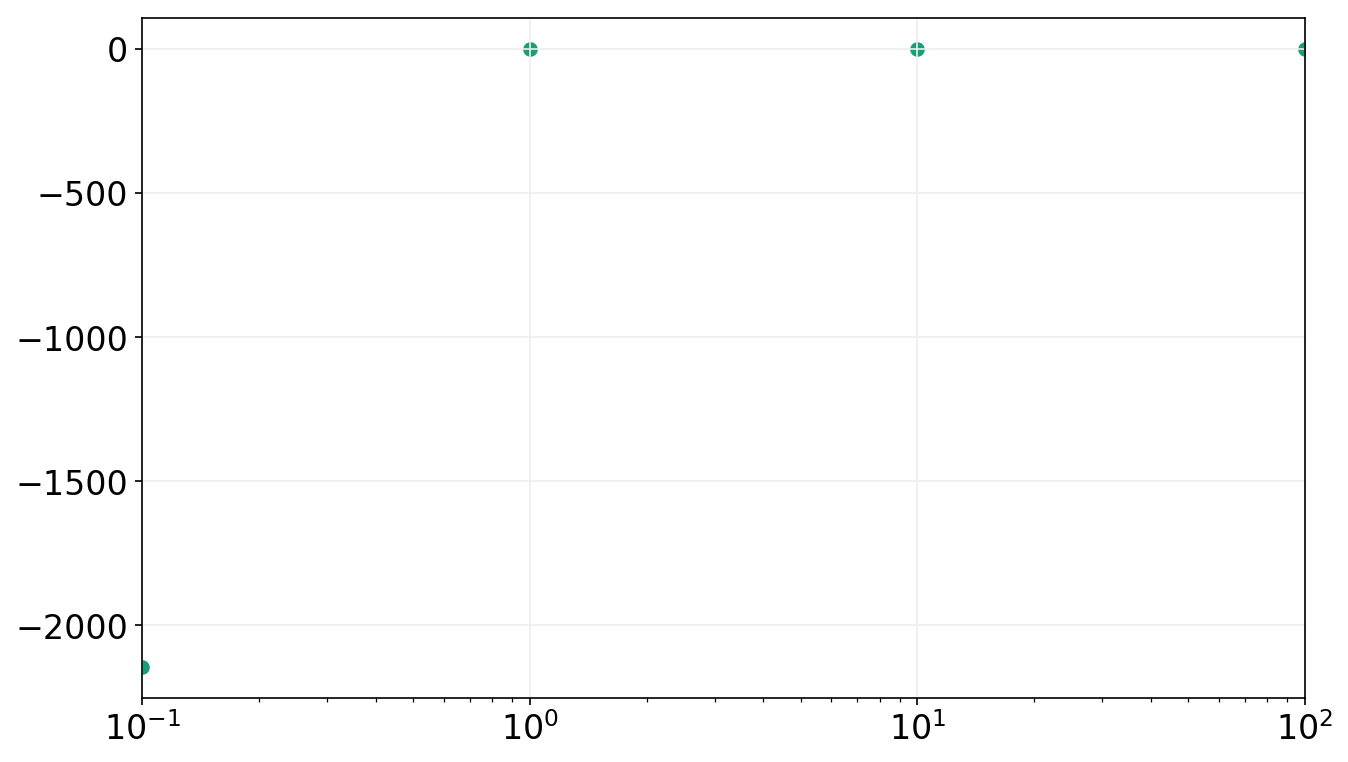

(-0.0717566308421119, 100)


In [255]:
rcParams['figure.figsize'] = (10, 6)
alphas = [0.1,1,10,100]
print(find_a(alphas, standardized_X_train, y_train, log_scale=True))

It looks like our optimal parameter will fall between 10^-3 and 0.1 for the alpha value.  Let's call our function again, limiting the range of the alpha parameters to only sweep from these values with linear spacing.

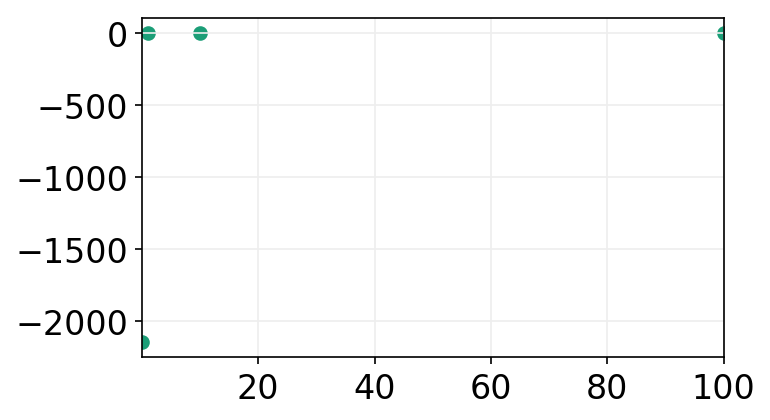

In [259]:
rcParams['figure.figsize'] = (5,3)
alphas2 = np.linspace(.001, .1, num=100)
optimal_score, optimal_lambda = find_a(alphas, standardized_X_train,\
                                       y_train)

Now, let's test this on our entire training set to see which features we can feel comfortable getting rid of. 

In [290]:
model = Lasso(.1)
results = model.fit(standardized_X_train, y_train)

In [291]:
results.coef_

array([ 0.        ,  0.        , -0.12721506, -0.        , -0.02722957,
       -0.        , -0.00929975,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.026517  ,  0.21036341, -0.07932745,
        0.        ,  0.12179706,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.24786249,  0.        , -0.3061012 ,
        0.0003322 ,  0.24126449, -0.05645296,  0.24364208,  0.        ,
        0.23422068, -0.17679989,  0.        , -0.2798878 ])

It looks like the lasso regularization reduces the coefficients of several features to 0. Let's look at the columns that it keeps:

In [292]:
X.iloc[:,np.where(abs(results.coef_) > 1.0e-12)[0]].columns

Index(['1 bed', '1 guest', '1 shared bath', '4 guests', '5 beds', '5 guests',
       '6 guests', 'free_cancel', 'long', 'plus', 'ratings',
       'rental_price_norm', 'reviews', 'entire_place', 'private_room',
       'shared_room'],
      dtype='object')

Not surprisingly, we kept our ratings, reviews, superhost, and plus columns, which were shown to be correlated with price (and by extension sqrt(price)) in the EDA notebook.  Interestingly, the longitude was also kept without the lattitude.  Based on intuition, I am going to keep the rental_price_norm feature as well as the lattiude feature and increase the polynomial of the fit to see if we can extract any more relationships between the response and the predictor. 

In [297]:
X_train_reduced = X_train[['1 bed', '1 guest', '1 shared bath', '4 guests', '5 beds', '5 guests',
       '6 guests', 'free_cancel', 'long', 'plus', 'ratings',
       'rental_price_norm', 'reviews', 'entire_place', 'private_room',
       'shared_room']]

In [298]:
X_test_reduced = X_test[['1 bed', '1 guest', '1 shared bath', '4 guests', '5 beds', '5 guests',
       '6 guests', 'free_cancel', 'long', 'plus', 'ratings',
       'rental_price_norm', 'reviews', 'entire_place', 'private_room',
       'shared_room']]

In [301]:
reduced_data = data[['1 bed', '1 guest', '1 shared bath',\
       '6 guests', 'free_cancel', 'plus', 'ratings',\
       'rental_price_norm', 'reviews', 'entire_place', 'private_room',\
       'shared_room','sqrt_price']]

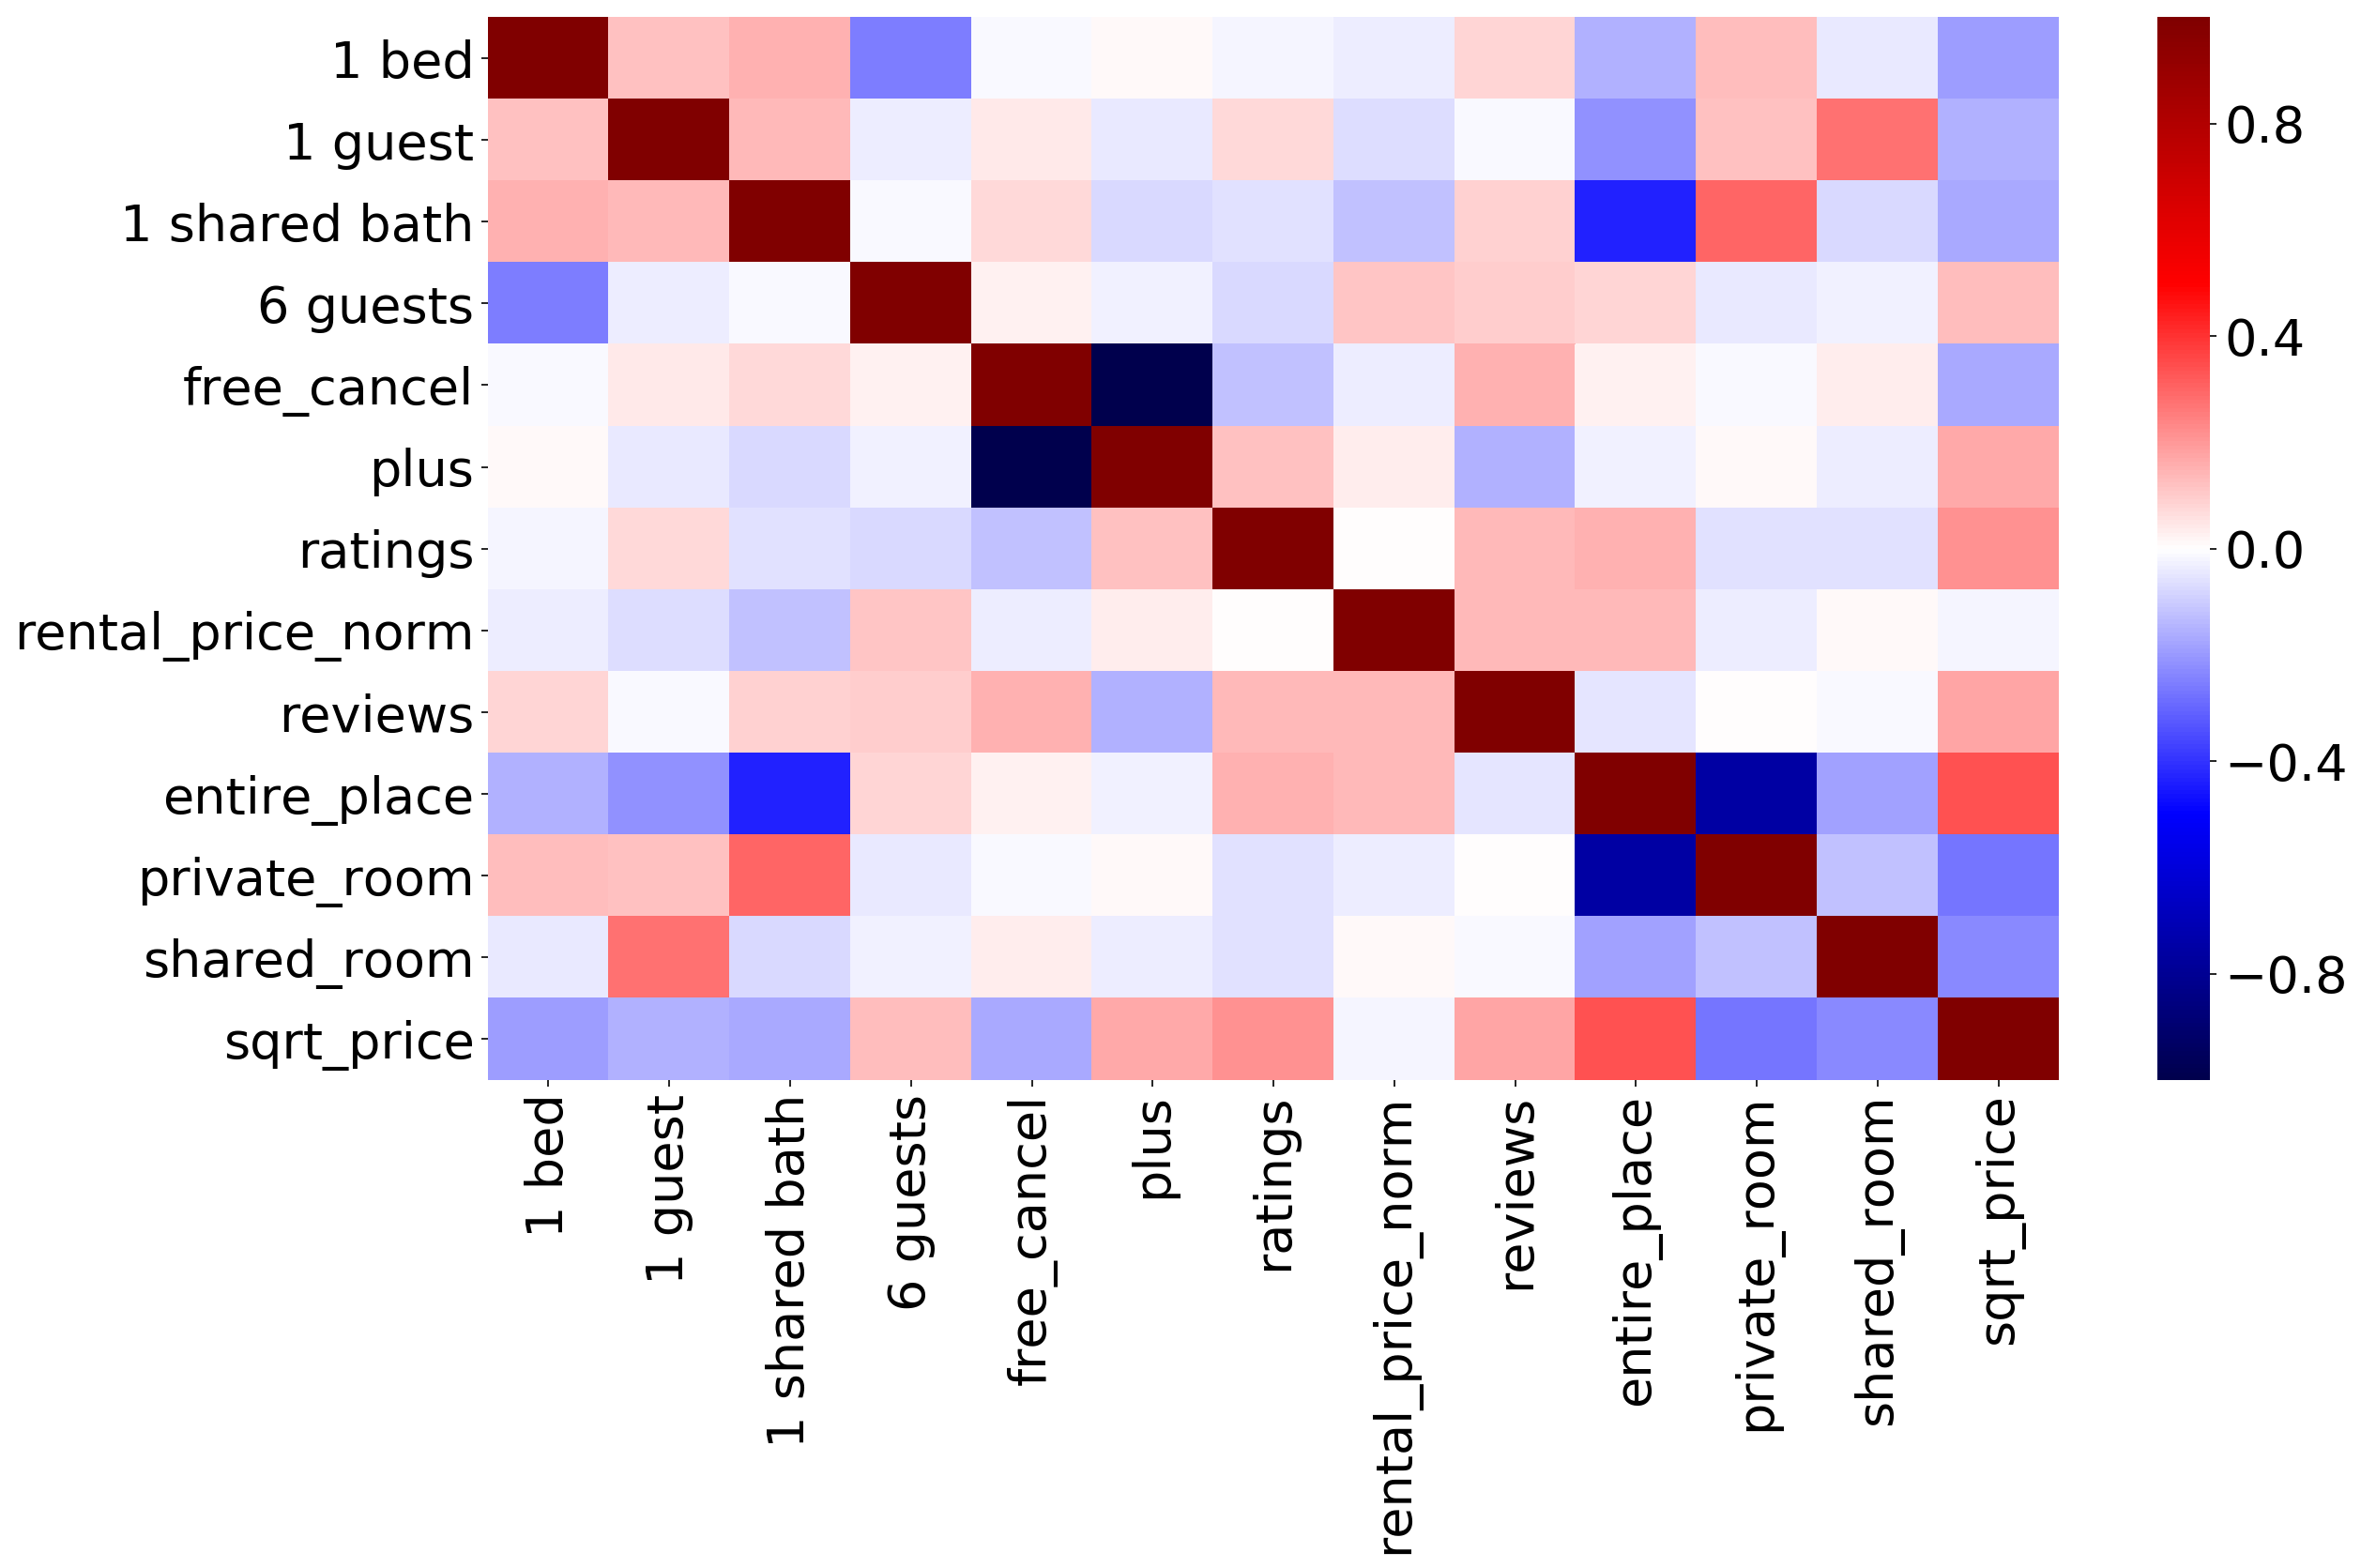

In [308]:
rcParams['figure.figsize'] = (20, 12)
rcParams['font.size'] = 26
fig, ax = plt.subplots()
sns.heatmap(reduced_data.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1, ax = ax)
fig.savefig('heatmap.svg', format = 'svg')

In [309]:
reduced_model_no_reg = LinearRegression()
reduced_model_no_reg.fit(X_train_reduced, y_train)
pred_reduced_no_reg = reduced_model_no_reg.predict(X_test_reduced)
mse(y_test**2, pred_reduced_no_reg**2)

1376.7983001863818

In [314]:
X_train_reduced.columns

Index(['1 bed', '1 guest', '1 shared bath', '4 guests', '5 beds', '5 guests',
       '6 guests', 'free_cancel', 'long', 'plus', 'ratings',
       'rental_price_norm', 'reviews', 'entire_place', 'private_room',
       'shared_room'],
      dtype='object')

In [324]:
really_reduced = X_train_reduced[['plus', 'ratings',\
       'rental_price_norm', 'reviews', 'entire_place', 'private_room',\
       'shared_room']]

In [ ]:
really_reduced_model_no_reg = LinearRegression()
really_reduced_model_no_reg.fit(X_train_reduced, y_train)
really_pred_reduced_no_reg = really_reduced_model_no_reg.predict(X_test_reduced)
mse(y_test**2, pred_reduced_no_reg**2)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text xticklabel objects>)

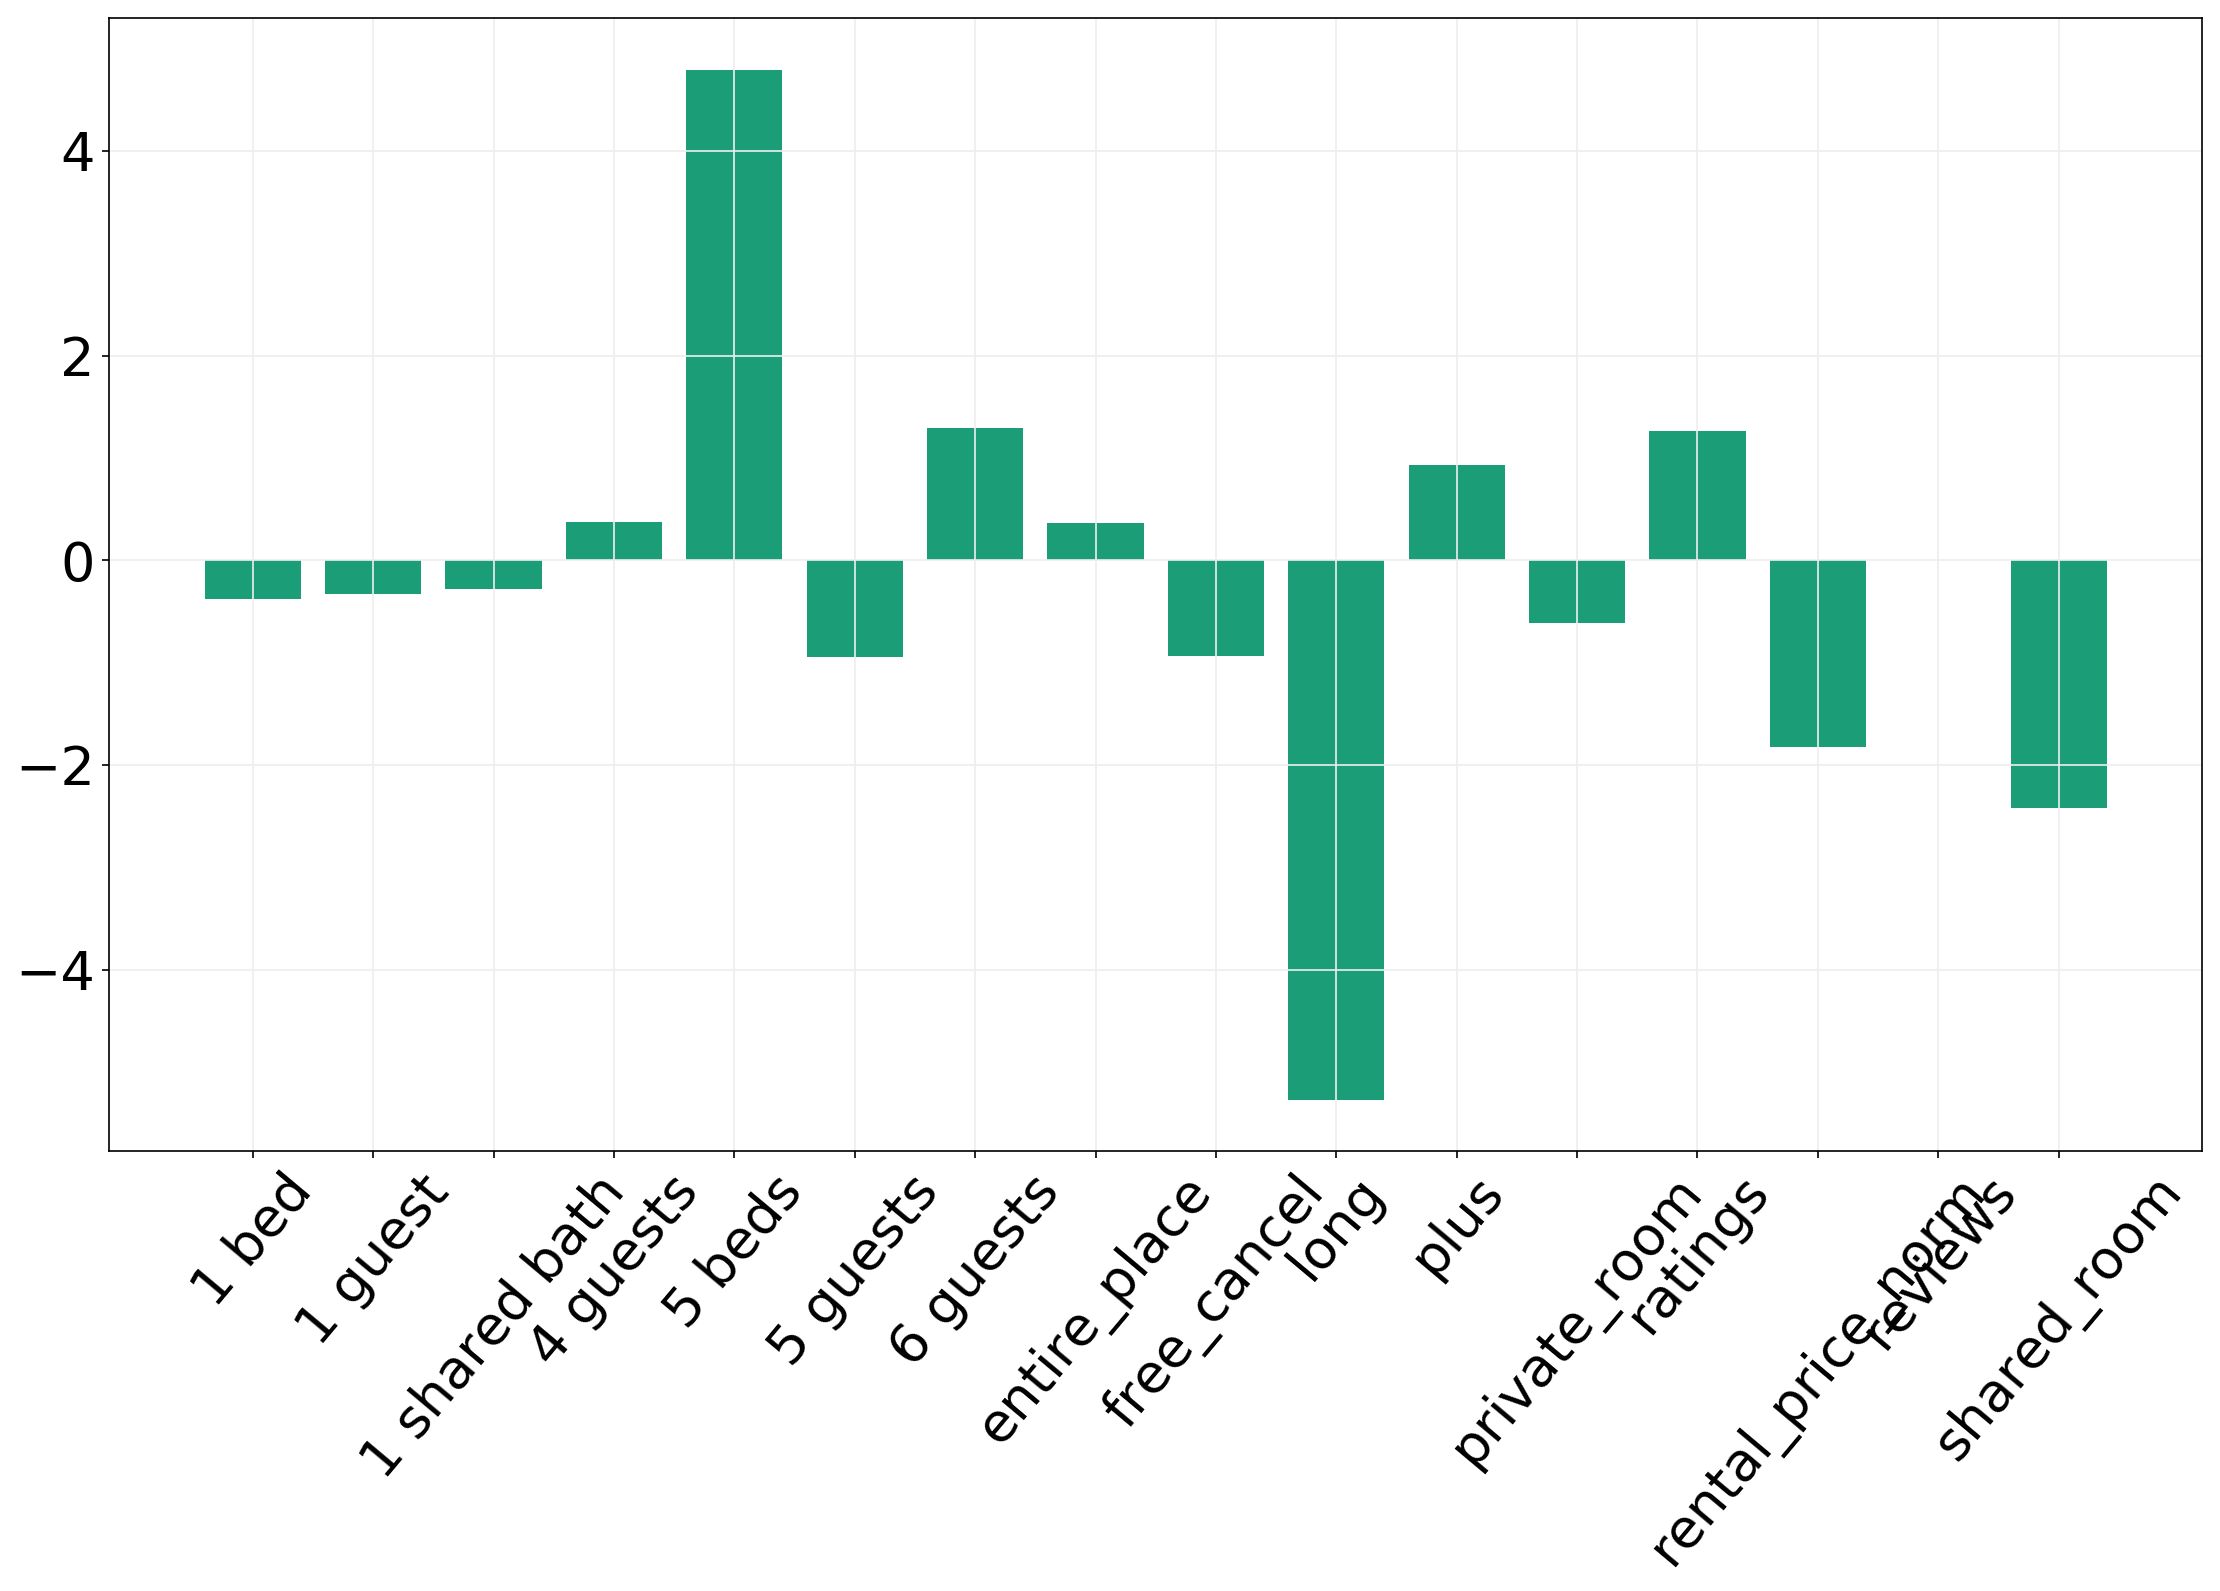

In [322]:
plt.bar(X_train_reduced.columns,reduced_model_no_reg.coef_)
plt.xticks(rotation = 50)


It looks like doing vanilla linear regression improves our model more than when we integrate ridge regression.  The likely cause is that our model is not overfitting so there is no need to regularize.  